In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#import sympy as sp
import random
import openpyxl
import pandas as pd
from IPython.display import display
import scipy.io
from mat4py import loadmat
import keras
from keras.callbacks import History,EarlyStopping
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.layers.recurrent import GRU
from keras.layers import Bidirectional
from sklearn.model_selection import train_test_split
from keras.models import load_model
from keras.optimizers import RMSprop, Adam
from keras.layers import Reshape
import time
from keras.models import load_model

Using TensorFlow backend.


In [2]:
start = time.time()
Results_cross = []

def findAllFile_cross(base):
    for root, ds, fs in os.walk(base):
        for f in fs:
            if f.endswith('.mat'):
                fullname = os.path.join(root, f)
                mat = loadmat(fullname) 
                Results_cross.append(mat)
                yield fullname

#build temp list for crossing
IKlist = []
IAlist = []
GVlist = []
EPlist = []
EP_OBSlist = []
AP_01list = []
AP_02list = []
AP_03list = []
AP_04list = []
AP_05list = []
AP_06list = []


AP_01_array = np.empty((1,101))
AP_02_array = np.empty((1,101))
AP_03_array = np.empty((1,101))
AP_04_array = np.empty((1,101))
AP_05_array = np.empty((1,101))
AP_06_array = np.empty((1,101))

IK_array = np.empty((6,101,3))
IK_tay = np.empty((3,101))
IK_toay = np.empty((6,3,101))


IA_array = np.empty((4,101,1))
IA_tay = np.empty((1,101))
IA_toay = np.empty((4,1,101))

GV_array = np.empty((1,101,1))
GV_tay = np.empty((1,101))
GV_toay = np.empty((1,1,101))



Feature = np.empty((29,101))



def getfeature(value):
    
    
    #EP_array = np.empty((1))
    o = Results_cross[value]['Results']['EP']
    EPlist.append(o)
    
    EP_array = np.array(EPlist[value]['LeadingToeClearance'])
    Feature_obstacles1 = EP_array
    
    
    x = Results_cross[value]['Results']['IK']
    IKlist.append(x)
    
    IK_array[0,:,:] = np.array(IKlist[value]['LeadingAnkle'])
    IK_array[1,:,:] = np.array(IKlist[value]['LeadingHip'])
    IK_array[2,:,:] = np.array(IKlist[value]['LeadingKnee'])
    IK_array[3,:,:] = np.array(IKlist[value]['TrailingAnkle'])
    IK_array[4,:,:] = np.array(IKlist[value]['TrailingHip'])
    IK_array[5,:,:] = np.array(IKlist[value]['TrailingKnee'])
    
    
   
    for i in range(IK_toay.shape[0]):  
        IK_tay = np.transpose(IK_array[i])
        IK_toay[i,:,:] = IK_tay
   

    k = 0
    for i in range(IK_toay.shape[0]):
        for j in range(IK_toay.shape[1]):
            Feature[k,:] = IK_toay[i,j,:] #k = 3*i+j
            k += 1
    
    y = Results_cross[value]['Results']['IA']
    IAlist.append(y)
    IA_array[0,:,:] = np.array(IAlist[value]['FrontalIA'])
    IA_array[1,:,:] = np.array(IAlist[value]['FrontalRCIA'])
    IA_array[2,:,:] = np.array(IAlist[value]['SagittalIA'])
    IA_array[3,:,:] = np.array(IAlist[value]['SagittalRCIA'])
    
    for i in range(IA_array.shape[0]):
      IA_tay = np.transpose(IA_array[i])
      IA_toay[i,:,:] = IA_tay
      

    for i in range(IA_toay.shape[0]):
        for j in range(IA_toay.shape[1]):
            Feature[k,:] = IA_toay[i,j,:] #k = 3*i+j
            k += 1
    
    z = Results_cross[value]['Results']['SelfDefinedVariables']
    GVlist.append(z)
    GV_array[0,:,:] = np.array(GVlist[value]['GaitVelocity'])
    GV_tay = np.transpose(GV_array[0])
    GV_toay[0,:,:] = GV_tay
    Feature[22,:] = GV_toay[0,0,:]
    '''
    #從EP取出障礙物高度並與Clearance相加取得toe離地高度
    A = Results_cross[value]['Results']['EP']
    EP_OBSlist.append(A)
    
    EP_OBS_array = np.array(EP_OBSlist[value]['OBS']+EP_OBSlist[value]['LeadingToeClearance'])
    Feature_obstacles1 = EP_OBS_array
    '''
    
    #取出AP單一值資料並變成序列資料
    B = Results_cross[value]['Results']['AP']['BodyHeight']
    AP_01list.append(B)
    for i in range(101):
        AP_01_array[:,i] = np.array(AP_01list[value])
        Feature[23,:] = AP_01_array[:,i]
    
    C = Results_cross[value]['Results']['AP']['BW']
    AP_02list.append(C)
    for i in range(101):
        AP_02_array[:,i] = np.array(AP_02list[value])
        Feature[24,:] = AP_02_array[:,i]
    
    D = Results_cross[value]['Results']['AP']['FootLength']
    AP_03list.append(D)
    for i in range(101):
        AP_03_array[:,i] = np.array(AP_03list[value])
        Feature[25,:] = AP_03_array[:,i]
        
    E = Results_cross[value]['Results']['AP']['HipWidth']
    AP_04list.append(E)
    for i in range(101):
        AP_04_array[:,i] = np.array(AP_04list[value])
        Feature[26,:] = AP_04_array[:,i]
    
    F = Results_cross[value]['Results']['AP']['ShankLength']
    AP_05list.append(F)
    for i in range(101):
        AP_05_array[:,i] = np.array(AP_05list[value])
        Feature[27,:] = AP_05_array[:,i]
    
    G = Results_cross[value]['Results']['AP']['ThighLength']
    AP_06list.append(G)
    for i in range(101):
        AP_06_array[:,i] = np.array(AP_06list[value])
        Feature[28,:] = AP_06_array[:,i]
   
    
    
    
        
    return Feature,Feature_obstacles1

Feature_cross = np.empty((204,29,101))
Feature_obstacles = np.empty((204))
FEATUREccc = np.empty((29,101))



base = r"C:/Users/Danny Lee/Desktop/motion hw/final/Results_cross/"


for i in findAllFile_cross(base):
    print(i)



for i in range(len(Results_cross)):
    FEATUREccc,Feature_obs= getfeature(i)
    Feature_cross[i,:,:] = FEATUREccc
    Feature_obstacles[i] = Feature_obs

    
print(Feature_cross)

C:/Users/Danny Lee/Desktop/motion hw/final/Results_cross/E01\OC10\Trial40\Results.mat
C:/Users/Danny Lee/Desktop/motion hw/final/Results_cross/E01\OC10\Trial41\Results.mat
C:/Users/Danny Lee/Desktop/motion hw/final/Results_cross/E01\OC10\Trial49\Results.mat
C:/Users/Danny Lee/Desktop/motion hw/final/Results_cross/E01\OC10\Trial50\Results.mat
C:/Users/Danny Lee/Desktop/motion hw/final/Results_cross/E01\OC20\Trial100\Results.mat
C:/Users/Danny Lee/Desktop/motion hw/final/Results_cross/E01\OC20\Trial109\Results.mat
C:/Users/Danny Lee/Desktop/motion hw/final/Results_cross/E01\OC20\Trial110\Results.mat
C:/Users/Danny Lee/Desktop/motion hw/final/Results_cross/E01\OC20\Trial99\Results.mat
C:/Users/Danny Lee/Desktop/motion hw/final/Results_cross/E01\OC30\Trial113\Results.mat
C:/Users/Danny Lee/Desktop/motion hw/final/Results_cross/E01\OC30\Trial114\Results.mat
C:/Users/Danny Lee/Desktop/motion hw/final/Results_cross/E01\OC30\Trial116\Results.mat
C:/Users/Danny Lee/Desktop/motion hw/final/Resul

C:/Users/Danny Lee/Desktop/motion hw/final/Results_cross/E13\OC10\Trial50\Results.mat
C:/Users/Danny Lee/Desktop/motion hw/final/Results_cross/E13\OC10\Trial52\Results.mat
C:/Users/Danny Lee/Desktop/motion hw/final/Results_cross/E13\OC10\Trial54\Results.mat
C:/Users/Danny Lee/Desktop/motion hw/final/Results_cross/E13\OC20\Trial87\Results.mat
C:/Users/Danny Lee/Desktop/motion hw/final/Results_cross/E13\OC20\Trial88\Results.mat
C:/Users/Danny Lee/Desktop/motion hw/final/Results_cross/E13\OC20\Trial90\Results.mat
C:/Users/Danny Lee/Desktop/motion hw/final/Results_cross/E13\OC20\Trial91\Results.mat
C:/Users/Danny Lee/Desktop/motion hw/final/Results_cross/E13\OC30\Trial107\Results.mat
C:/Users/Danny Lee/Desktop/motion hw/final/Results_cross/E13\OC30\Trial108\Results.mat
C:/Users/Danny Lee/Desktop/motion hw/final/Results_cross/E13\OC30\Trial113\Results.mat
C:/Users/Danny Lee/Desktop/motion hw/final/Results_cross/E13\OC30\Trial116\Results.mat
C:/Users/Danny Lee/Desktop/motion hw/final/Results

In [7]:
X_normalized = (Feature_cross - Feature_cross.mean()) / Feature_cross.std()
X_train, X_test, y_train, y_test = train_test_split(X_normalized, Feature_obstacles, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
print(len(X_train),len(y_train))
print(len(X_val),len(y_val))
print(len(X_test),len(y_test))
#train=0.8，val=0.1，test=0.1

# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[2] , X_train.shape[1])
X_val =X_val.reshape(X_val.shape[0],X_val.shape[2] , X_val.shape[1])
X_test = X_test.reshape(X_test.shape[0],X_test.shape[2] , X_test.shape[1])

122 122
41 41
41 41


In [15]:
class SelfAttention(keras.layers.Layer):
        def __init__(self, attention_units):
            super(SelfAttention, self).__init__()
            self.attention_units = attention_units

        def build(self, input_shape):
            self.W = self.add_weight(
                shape=(input_shape[-1], self.attention_units),
                initializer="glorot_uniform",
                trainable=True
            )
            self.b = self.add_weight(
                shape=(self.attention_units,),
                initializer="zeros",
                trainable=True
            )
            self.V = self.add_weight(
                shape=(self.attention_units, 1),
                initializer="glorot_uniform",
                trainable=True
            )
    
        def call(self, inputs):
            score = keras.activations.tanh(keras.backend.dot(inputs, self.W) + self.b)
            attention_weights = keras.activations.softmax(keras.backend.dot(score, self.V), axis=1)
            attended_input = inputs * attention_weights
            return attended_input

In [16]:
import tensorflow as tf
model = load_model('C:/Users/Danny Lee/Desktop/motion hw/final/LSTM model performance/try_0612_dropout/Regression.h5',custom_objects={'Attention':Attention})

NameError: name 'Attention' is not defined

In [5]:
'''
#import tensorflow as tf
d = 0.01
model = Sequential()
input_shape=(101,29)
model.add(Bidirectional(GRU(64, input_shape=(101,29), return_sequences=False)))
model.add(Dropout(d))
model.add(SelfAttention(64))
model.add(Dense(32, activation='relu'))
model.add(SelfAttention(32))
model.add(Dense(32, activation='relu'))
model.add(SelfAttention(32))
model.add(Dense(16, activation='relu'))
model.add(SelfAttention(16))
model.add(Dense(16, activation='relu'))
model.add(SelfAttention(16))
model.add(Dense(8, activation='relu'))
model.add(SelfAttention(8))
model.add(Dense(8, activation='relu'))
model.add(SelfAttention(8))
model.add(Dense(4, activation='relu'))
model.add(SelfAttention(4))
model.add(Dense(4, activation='relu'))
model.add(SelfAttention(4))
model.add(Dense(2, activation='relu'))
model.add(SelfAttention(2))
model.add(Dense(2, activation='relu'))
model.add(SelfAttention(2))
model.add(Dense(1, activation='linear'))

#model = load_model('C:/Users/Danny Lee/Desktop/motion hw/final/LSTM model performance/try_best_nodropout/Regression.h5')
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer= opt)
start_fitting = time.time()
#model.load_weights('C:/Users/Danny Lee/Desktop/motion hw/final/LSTM model performance/try_best_nodropout/Regression_weights.h5'.encode('utf-8'))
#model = tf.keras.models.load_model('C:/Users/Danny Lee/Desktop/motion hw/final/LSTM model performance/try_best_nodropout/Regression_weights.h5')
model.fit(X_train, y_train, epochs=2000, batch_size=32,validation_data=(X_val, y_val))
fitting_model_time = time.time()
print('Training Model took: ', fitting_model_time - start_fitting)
'''


Train on 122 samples, validate on 41 samples
Epoch 1/2000
122/122 [==============================] - 1s 10ms/step - loss: 32350.0562 - val_loss: 36101.7703
Epoch 2/2000
122/122 [==============================] - 0s 965us/step - loss: 32348.3335 - val_loss: 36098.6680
Epoch 3/2000
122/122 [==============================] - 0s 940us/step - loss: 32344.7725 - val_loss: 36093.7489
Epoch 4/2000
122/122 [==============================] - 0s 932us/step - loss: 32339.0286 - val_loss: 36085.5034
Epoch 5/2000
122/122 [==============================] - 0s 916us/step - loss: 32329.6782 - val_loss: 36072.4417
Epoch 6/2000
122/122 [==============================] - 0s 883us/step - loss: 32314.7738 - val_loss: 36051.7772
Epoch 7/2000
122/122 [==============================] - 0s 875us/step - loss: 32291.0052 - val_loss: 36018.2790
Epoch 8/2000
122/122 [==============================] - 0s 867us/step - loss: 32251.8726 - val_loss: 35961.6623
Epoch 9/2000
122/122 [==============================] - 0s 

122/122 [==============================] - 0s 1ms/step - loss: 2754.3942 - val_loss: 3787.7580
Epoch 147/2000
122/122 [==============================] - 0s 1ms/step - loss: 2781.9036 - val_loss: 3798.1672
Epoch 148/2000
122/122 [==============================] - 0s 1ms/step - loss: 2738.1698 - val_loss: 3743.3171
Epoch 149/2000
122/122 [==============================] - 0s 1ms/step - loss: 2747.6474 - val_loss: 3722.9484
Epoch 150/2000
122/122 [==============================] - 0s 1ms/step - loss: 2785.2542 - val_loss: 3692.9790
Epoch 151/2000
122/122 [==============================] - 0s 1ms/step - loss: 2800.0173 - val_loss: 3698.7063
Epoch 152/2000
122/122 [==============================] - 0s 1ms/step - loss: 2795.1054 - val_loss: 3804.3931
Epoch 153/2000
122/122 [==============================] - 0s 1ms/step - loss: 2789.9293 - val_loss: 3850.3494
Epoch 154/2000
122/122 [==============================] - 0s 1ms/step - loss: 2782.1308 - val_loss: 3776.9512
Epoch 155/2000
122/122 [=

122/122 [==============================] - 0s 1ms/step - loss: 2177.1838 - val_loss: 3773.0349
Epoch 295/2000
122/122 [==============================] - 0s 1ms/step - loss: 2090.8703 - val_loss: 3742.7882
Epoch 296/2000
122/122 [==============================] - 0s 1ms/step - loss: 2070.4559 - val_loss: 3627.3737
Epoch 297/2000
122/122 [==============================] - 0s 1ms/step - loss: 1981.0432 - val_loss: 3693.4902
Epoch 298/2000
122/122 [==============================] - 0s 1ms/step - loss: 1959.9124 - val_loss: 3965.2809
Epoch 299/2000
122/122 [==============================] - 0s 1ms/step - loss: 2071.2737 - val_loss: 3797.6138
Epoch 300/2000
122/122 [==============================] - 0s 1ms/step - loss: 2006.7969 - val_loss: 3686.3919
Epoch 301/2000
122/122 [==============================] - 0s 1ms/step - loss: 1952.8695 - val_loss: 3649.8283
Epoch 302/2000
122/122 [==============================] - 0s 1ms/step - loss: 1997.1471 - val_loss: 3794.7725
Epoch 303/2000
122/122 [=

122/122 [==============================] - 0s 1ms/step - loss: 2200.1872 - val_loss: 3717.2981
Epoch 443/2000
122/122 [==============================] - 0s 1ms/step - loss: 2131.6777 - val_loss: 3405.1219
Epoch 444/2000
122/122 [==============================] - 0s 1ms/step - loss: 2197.2009 - val_loss: 3508.5118
Epoch 445/2000
122/122 [==============================] - 0s 1ms/step - loss: 2104.9313 - val_loss: 3727.9218
Epoch 446/2000
122/122 [==============================] - 0s 1ms/step - loss: 2123.0049 - val_loss: 3506.7520
Epoch 447/2000
122/122 [==============================] - 0s 1ms/step - loss: 2124.1976 - val_loss: 3453.8106
Epoch 448/2000
122/122 [==============================] - 0s 1ms/step - loss: 2096.3066 - val_loss: 3568.1204
Epoch 449/2000
122/122 [==============================] - 0s 1ms/step - loss: 2152.7062 - val_loss: 3794.2626
Epoch 450/2000
122/122 [==============================] - 0s 1ms/step - loss: 2104.1268 - val_loss: 3479.4758
Epoch 451/2000
122/122 [=

122/122 [==============================] - 0s 1ms/step - loss: 2659.2745 - val_loss: 3532.1061
Epoch 591/2000
122/122 [==============================] - 0s 1ms/step - loss: 2732.4002 - val_loss: 3645.7976
Epoch 592/2000
122/122 [==============================] - 0s 1ms/step - loss: 2729.4895 - val_loss: 3765.9086
Epoch 593/2000
122/122 [==============================] - 0s 1ms/step - loss: 2724.1199 - val_loss: 3802.4064
Epoch 594/2000
122/122 [==============================] - 0s 1ms/step - loss: 2718.2097 - val_loss: 3725.3601
Epoch 595/2000
122/122 [==============================] - 0s 1ms/step - loss: 2738.8000 - val_loss: 3632.7037
Epoch 596/2000
122/122 [==============================] - 0s 1ms/step - loss: 2747.3716 - val_loss: 3670.8601
Epoch 597/2000
122/122 [==============================] - 0s 1ms/step - loss: 2730.8955 - val_loss: 3734.4000
Epoch 598/2000
122/122 [==============================] - 0s 1ms/step - loss: 2712.4660 - val_loss: 3707.9567
Epoch 599/2000
122/122 [=

122/122 [==============================] - 0s 1ms/step - loss: 2403.7087 - val_loss: 3814.2324
Epoch 739/2000
122/122 [==============================] - 0s 1ms/step - loss: 2442.0206 - val_loss: 3925.1009
Epoch 740/2000
122/122 [==============================] - 0s 1ms/step - loss: 2369.5739 - val_loss: 3798.1577
Epoch 741/2000
122/122 [==============================] - 0s 1ms/step - loss: 2360.2294 - val_loss: 3752.8758
Epoch 742/2000
122/122 [==============================] - 0s 1ms/step - loss: 2413.2677 - val_loss: 3766.0450
Epoch 743/2000
122/122 [==============================] - 0s 1ms/step - loss: 2404.8101 - val_loss: 3950.0495
Epoch 744/2000
122/122 [==============================] - 0s 1ms/step - loss: 2399.3184 - val_loss: 3975.0186
Epoch 745/2000
122/122 [==============================] - 0s 1ms/step - loss: 2385.9405 - val_loss: 3776.8339
Epoch 746/2000
122/122 [==============================] - 0s 1ms/step - loss: 2443.7350 - val_loss: 3769.2820
Epoch 747/2000
122/122 [=

122/122 [==============================] - 0s 1ms/step - loss: 2019.6389 - val_loss: 4364.1049
Epoch 887/2000
122/122 [==============================] - 0s 1ms/step - loss: 2005.5457 - val_loss: 4303.0896
Epoch 888/2000
122/122 [==============================] - 0s 1ms/step - loss: 1993.6437 - val_loss: 4361.2421
Epoch 889/2000
122/122 [==============================] - 0s 1ms/step - loss: 1929.5433 - val_loss: 4402.6723
Epoch 890/2000
122/122 [==============================] - 0s 1ms/step - loss: 2007.1347 - val_loss: 4413.8616
Epoch 891/2000
122/122 [==============================] - 0s 1ms/step - loss: 2033.5512 - val_loss: 4476.8090
Epoch 892/2000
122/122 [==============================] - 0s 1ms/step - loss: 2009.8452 - val_loss: 4318.0273
Epoch 893/2000
122/122 [==============================] - 0s 1ms/step - loss: 2000.2727 - val_loss: 4407.8778
Epoch 894/2000
122/122 [==============================] - 0s 1ms/step - loss: 2013.0270 - val_loss: 4543.3389
Epoch 895/2000
122/122 [=

122/122 [==============================] - 0s 1ms/step - loss: 1916.1519 - val_loss: 3848.3059
Epoch 1035/2000
122/122 [==============================] - 0s 1ms/step - loss: 1914.4457 - val_loss: 3833.4914
Epoch 1036/2000
122/122 [==============================] - 0s 1ms/step - loss: 1895.5773 - val_loss: 3627.9975
Epoch 1037/2000
122/122 [==============================] - 0s 1ms/step - loss: 1899.4839 - val_loss: 3808.8498
Epoch 1038/2000
122/122 [==============================] - 0s 1ms/step - loss: 1909.6351 - val_loss: 3815.2652
Epoch 1039/2000
122/122 [==============================] - 0s 1ms/step - loss: 1916.1522 - val_loss: 3739.5847
Epoch 1040/2000
122/122 [==============================] - 0s 1ms/step - loss: 1878.7998 - val_loss: 3722.7947
Epoch 1041/2000
122/122 [==============================] - 0s 1ms/step - loss: 1937.4000 - val_loss: 3797.6348
Epoch 1042/2000
122/122 [==============================] - 0s 1ms/step - loss: 1889.1837 - val_loss: 3854.3774
Epoch 1043/2000
1

Epoch 1108/2000
122/122 [==============================] - 0s 1ms/step - loss: 2030.8772 - val_loss: 3781.9542
Epoch 1109/2000
122/122 [==============================] - 0s 1ms/step - loss: 1890.0329 - val_loss: 3397.8643
Epoch 1110/2000
122/122 [==============================] - 0s 1ms/step - loss: 1907.9150 - val_loss: 3544.2365
Epoch 1111/2000
122/122 [==============================] - 0s 1ms/step - loss: 1972.5211 - val_loss: 3878.7958
Epoch 1112/2000
122/122 [==============================] - 0s 1ms/step - loss: 1852.5214 - val_loss: 3593.9070
Epoch 1113/2000
122/122 [==============================] - 0s 1ms/step - loss: 1804.9623 - val_loss: 3565.7738
Epoch 1114/2000
122/122 [==============================] - 0s 1ms/step - loss: 1824.3345 - val_loss: 3567.3188
Epoch 1115/2000
122/122 [==============================] - 0s 1ms/step - loss: 1875.8695 - val_loss: 3846.8068
Epoch 1116/2000
122/122 [==============================] - 0s 1ms/step - loss: 1796.7624 - val_loss: 3561.2754
E

Epoch 1182/2000
122/122 [==============================] - 0s 1ms/step - loss: 1795.9151 - val_loss: 3641.8287
Epoch 1183/2000
122/122 [==============================] - 0s 1ms/step - loss: 1785.8410 - val_loss: 3742.2628
Epoch 1184/2000
122/122 [==============================] - 0s 1ms/step - loss: 1697.5124 - val_loss: 3883.1528
Epoch 1185/2000
122/122 [==============================] - 0s 1ms/step - loss: 1625.8626 - val_loss: 3658.4562
Epoch 1186/2000
122/122 [==============================] - 0s 1ms/step - loss: 1696.5569 - val_loss: 3822.6984
Epoch 1187/2000
122/122 [==============================] - 0s 1ms/step - loss: 1621.1435 - val_loss: 3823.4465
Epoch 1188/2000
122/122 [==============================] - 0s 1ms/step - loss: 1701.4646 - val_loss: 3871.4041
Epoch 1189/2000
122/122 [==============================] - 0s 1ms/step - loss: 1551.1638 - val_loss: 3996.3750
Epoch 1190/2000
122/122 [==============================] - 0s 1ms/step - loss: 1750.7961 - val_loss: 3986.9604
E

Epoch 1256/2000
122/122 [==============================] - 0s 1ms/step - loss: 1503.3800 - val_loss: 5255.1132
Epoch 1257/2000
122/122 [==============================] - 0s 1ms/step - loss: 1470.6447 - val_loss: 5096.9357
Epoch 1258/2000
122/122 [==============================] - 0s 1ms/step - loss: 1552.6968 - val_loss: 5219.2982
Epoch 1259/2000
122/122 [==============================] - 0s 1ms/step - loss: 1422.2627 - val_loss: 5218.1229
Epoch 1260/2000
122/122 [==============================] - 0s 1ms/step - loss: 1417.3776 - val_loss: 5249.5961
Epoch 1261/2000
122/122 [==============================] - 0s 1ms/step - loss: 1361.3484 - val_loss: 5186.1784
Epoch 1262/2000
122/122 [==============================] - 0s 1ms/step - loss: 1371.9416 - val_loss: 5211.9259
Epoch 1263/2000
122/122 [==============================] - 0s 1ms/step - loss: 1329.5247 - val_loss: 5316.5928
Epoch 1264/2000
122/122 [==============================] - 0s 1ms/step - loss: 1325.1672 - val_loss: 5385.7954
E

Epoch 1330/2000
122/122 [==============================] - 0s 1ms/step - loss: 1707.5989 - val_loss: 3437.9474
Epoch 1331/2000
122/122 [==============================] - 0s 1ms/step - loss: 1675.0386 - val_loss: 3302.1970
Epoch 1332/2000
122/122 [==============================] - 0s 1ms/step - loss: 1593.7070 - val_loss: 3599.0333
Epoch 1333/2000
122/122 [==============================] - 0s 1ms/step - loss: 1517.8236 - val_loss: 3602.4145
Epoch 1334/2000
122/122 [==============================] - 0s 1ms/step - loss: 1394.9542 - val_loss: 3575.1385
Epoch 1335/2000
122/122 [==============================] - 0s 1ms/step - loss: 1387.4012 - val_loss: 3568.3169
Epoch 1336/2000
122/122 [==============================] - 0s 1ms/step - loss: 1369.5085 - val_loss: 3835.5746
Epoch 1337/2000
122/122 [==============================] - 0s 1ms/step - loss: 1346.6951 - val_loss: 4204.2043
Epoch 1338/2000
122/122 [==============================] - 0s 1ms/step - loss: 1333.8514 - val_loss: 4139.9675
E

Epoch 1404/2000
122/122 [==============================] - 0s 1ms/step - loss: 2789.9584 - val_loss: 4016.1073
Epoch 1405/2000
122/122 [==============================] - 0s 1ms/step - loss: 2579.2371 - val_loss: 4400.4094
Epoch 1406/2000
122/122 [==============================] - 0s 1ms/step - loss: 2561.6092 - val_loss: 3566.8973
Epoch 1407/2000
122/122 [==============================] - 0s 1ms/step - loss: 2509.2311 - val_loss: 3430.0725
Epoch 1408/2000
122/122 [==============================] - 0s 1ms/step - loss: 2588.2992 - val_loss: 3846.4027
Epoch 1409/2000
122/122 [==============================] - 0s 1ms/step - loss: 2494.3337 - val_loss: 3755.0258
Epoch 1410/2000
122/122 [==============================] - 0s 1ms/step - loss: 2509.1478 - val_loss: 3527.1786
Epoch 1411/2000
122/122 [==============================] - 0s 1ms/step - loss: 2441.0499 - val_loss: 3689.5179
Epoch 1412/2000
122/122 [==============================] - 0s 1ms/step - loss: 2440.4420 - val_loss: 3701.4760
E

Epoch 1478/2000
122/122 [==============================] - 0s 1ms/step - loss: 1663.5877 - val_loss: 3859.9217
Epoch 1479/2000
122/122 [==============================] - 0s 1ms/step - loss: 1689.3102 - val_loss: 3957.5181
Epoch 1480/2000
122/122 [==============================] - 0s 1ms/step - loss: 1665.1999 - val_loss: 3695.3674
Epoch 1481/2000
122/122 [==============================] - 0s 1ms/step - loss: 1678.4123 - val_loss: 3944.5669
Epoch 1482/2000
122/122 [==============================] - 0s 1ms/step - loss: 1710.2449 - val_loss: 3693.9940
Epoch 1483/2000
122/122 [==============================] - 0s 1ms/step - loss: 1585.3779 - val_loss: 3574.1509
Epoch 1484/2000
122/122 [==============================] - 0s 1ms/step - loss: 1734.1677 - val_loss: 3638.8912
Epoch 1485/2000
122/122 [==============================] - 0s 1ms/step - loss: 1553.9344 - val_loss: 3478.9236
Epoch 1486/2000
122/122 [==============================] - 0s 1ms/step - loss: 1618.1400 - val_loss: 3798.6796
E

Epoch 1552/2000
122/122 [==============================] - 0s 1ms/step - loss: 1116.4609 - val_loss: 3323.6478
Epoch 1553/2000
122/122 [==============================] - 0s 1ms/step - loss: 1191.7776 - val_loss: 3135.1319
Epoch 1554/2000
122/122 [==============================] - 0s 1ms/step - loss: 1168.9389 - val_loss: 3408.3752
Epoch 1555/2000
122/122 [==============================] - 0s 1ms/step - loss: 1154.1191 - val_loss: 3017.7480
Epoch 1556/2000
122/122 [==============================] - 0s 1ms/step - loss: 1177.3767 - val_loss: 2971.1889
Epoch 1557/2000
122/122 [==============================] - 0s 1ms/step - loss: 1166.4668 - val_loss: 3230.8846
Epoch 1558/2000
122/122 [==============================] - 0s 1ms/step - loss: 1205.5901 - val_loss: 2997.8378
Epoch 1559/2000
122/122 [==============================] - 0s 1ms/step - loss: 1174.3908 - val_loss: 2978.9223
Epoch 1560/2000
122/122 [==============================] - 0s 1ms/step - loss: 1196.9962 - val_loss: 3236.2047
E

122/122 [==============================] - 0s 1ms/step - loss: 1216.8745 - val_loss: 2873.6984
Epoch 1627/2000
122/122 [==============================] - 0s 1ms/step - loss: 1609.9040 - val_loss: 3520.8514
Epoch 1628/2000
122/122 [==============================] - 0s 1ms/step - loss: 1267.3507 - val_loss: 3729.8013
Epoch 1629/2000
122/122 [==============================] - 0s 1ms/step - loss: 1113.4287 - val_loss: 3404.3917
Epoch 1630/2000
122/122 [==============================] - 0s 1ms/step - loss: 1103.5611 - val_loss: 3304.1389
Epoch 1631/2000
122/122 [==============================] - 0s 1ms/step - loss: 1124.4450 - val_loss: 3250.0913
Epoch 1632/2000
122/122 [==============================] - 0s 1ms/step - loss: 1054.3960 - val_loss: 3051.9633
Epoch 1633/2000
122/122 [==============================] - 0s 1ms/step - loss: 914.7223 - val_loss: 3452.9898
Epoch 1634/2000
122/122 [==============================] - 0s 1ms/step - loss: 1089.0680 - val_loss: 3307.5167
Epoch 1635/2000
12

Epoch 1774/2000
122/122 [==============================] - 0s 1ms/step - loss: 1869.7474 - val_loss: 2880.5767
Epoch 1775/2000
122/122 [==============================] - 0s 1ms/step - loss: 1857.6402 - val_loss: 3256.4241
Epoch 1776/2000
122/122 [==============================] - 0s 1ms/step - loss: 1658.4097 - val_loss: 2857.1004
Epoch 1777/2000
122/122 [==============================] - 0s 1ms/step - loss: 1762.4571 - val_loss: 2773.4951
Epoch 1778/2000
122/122 [==============================] - 0s 1ms/step - loss: 1929.0608 - val_loss: 2837.7523
Epoch 1779/2000
122/122 [==============================] - 0s 1ms/step - loss: 1798.3660 - val_loss: 2996.3309
Epoch 1780/2000
122/122 [==============================] - 0s 1ms/step - loss: 1591.1858 - val_loss: 3016.1707
Epoch 1781/2000
122/122 [==============================] - 0s 1ms/step - loss: 1579.6331 - val_loss: 2595.7475
Epoch 1782/2000
122/122 [==============================] - 0s 1ms/step - loss: 1791.5439 - val_loss: 2655.3388
E

Epoch 1848/2000
122/122 [==============================] - 0s 1ms/step - loss: 1199.5128 - val_loss: 2628.3473
Epoch 1849/2000
122/122 [==============================] - 0s 1ms/step - loss: 1089.0349 - val_loss: 2331.6551
Epoch 1850/2000
122/122 [==============================] - 0s 1ms/step - loss: 999.8988 - val_loss: 2393.7883
Epoch 1851/2000
122/122 [==============================] - 0s 1ms/step - loss: 986.8168 - val_loss: 2551.1653
Epoch 1852/2000
122/122 [==============================] - 0s 1ms/step - loss: 996.3885 - val_loss: 2997.0667
Epoch 1853/2000
122/122 [==============================] - 0s 1ms/step - loss: 2556.6989 - val_loss: 3555.6443
Epoch 1854/2000
122/122 [==============================] - 0s 1ms/step - loss: 2431.9577 - val_loss: 3275.1653
Epoch 1855/2000
122/122 [==============================] - 0s 1ms/step - loss: 1990.2107 - val_loss: 2506.2094
Epoch 1856/2000
122/122 [==============================] - 0s 1ms/step - loss: 1575.2557 - val_loss: 2775.6660
Epoc

122/122 [==============================] - 0s 1ms/step - loss: 788.7973 - val_loss: 3469.6530
Epoch 1997/2000
122/122 [==============================] - 0s 1ms/step - loss: 806.1235 - val_loss: 3462.7354
Epoch 1998/2000
122/122 [==============================] - 0s 1ms/step - loss: 669.5143 - val_loss: 3332.6017
Epoch 1999/2000
122/122 [==============================] - 0s 1ms/step - loss: 666.9318 - val_loss: 3395.0332
Epoch 2000/2000
122/122 [==============================] - 0s 1ms/step - loss: 619.8315 - val_loss: 3090.7973
Training Model took:  277.72938084602356


In [6]:
'''
model.build(input_shape)
print(model.summary())
with open('./LSTM model performance/try_0612_dropout_adam/modelsummary.txt', 'w') as f:

    model.summary(print_fn=lambda x: f.write(x + '\n'))

#earlystopping
#monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=50, verbose=2, mode='auto', restore_best_weights=True)
#model.fit(X_train, y_train, nb_epoch = 1000, batch_size = 32,validation_data=(X_val, y_val),callbacks=[monitor]) #训练模型1000次
#epochxxx =  monitor.stopped_epoch+1   #len(model.history.history['loss'])
#print(epochxxx)    

#保存模型和權重
saved = model.save('./LSTM model performance/try_0612_dropout_adam/Regression.h5')    
model.save_weights('./LSTM model performance/try_0612_dropout_adam/Regression_weights.h5')  # to store
'''

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 128)               36096     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
self_attention_1 (SelfAttent (None, 128)               8320      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
self_attention_2 (SelfAttent (None, 32)                1088      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
self_attention_3 (SelfAttent (None, 32)               

In [17]:
#画出迭代loss和acc曲线
pd.DataFrame(model.history.history).plot()

NameError: name 'model' is not defined

122 122


TypeError: 'int' object is not iterable

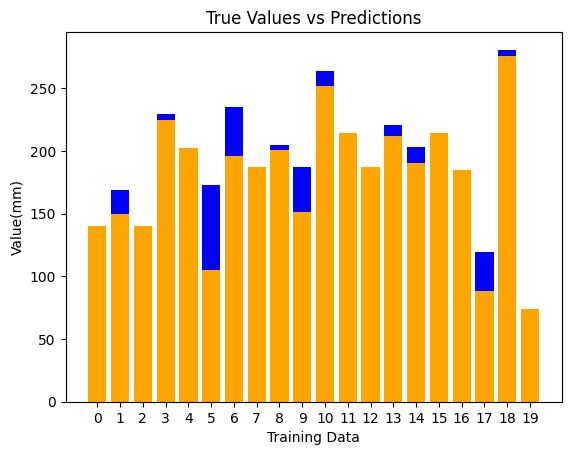

In [30]:
#在训练集上的拟合结果

y_train_predict=model.predict(X_train)
y_train_predict=y_train_predict[:,0]

#categories = ['Category 1', 'Category 2']
#x = range(len(categories))
a = np.arange(20)
b = np.arange(20)
print(len(y_train),len(y_train_predict))

plt.bar(a,y_train[0:20], label='True Values',color='blue')
plt.bar(b,y_train_predict[0:20],label='Predictions',color='orange')
#plt.title('title name')
plt.xlabel('Training Data')
plt.ylabel('Value(mm)')
plt.title('True Values vs Predictions')
#plt.xticks(a, 20)
plt.legend()
plt.show()



'''
print(X_train)
plt.plot(y_train, label='True Values')
plt.plot(y_train_predict, label='Predictions')
plt.xlabel('Training Data')
plt.ylabel('Value(mm)')
plt.title('True Values vs Predictions')
plt.legend()
plt.show()
'''
'''
draw=pd.concat([pd.DataFrame(y_train),pd.DataFrame(y_train_predict)],axis=1)
draw.iloc[100:150,0].plot(figsize=(12,6))
draw.iloc[100:150,1].plot(figsize=(12,6))
plt.legend(('real', 'predict'),fontsize='15')
plt.title("Training Data",fontsize='30') #添加标题
#plt.show()
#fig.savefig('./LSTM model performance/Regression_heel_test/train_Validation_loss.png')
#展示在训练集上的表现 
'''
'''
epocha=range(len(y_train))
epochb=range(len(y_train_predict))
plt.plot(epocha, y_train, 'g', label='real')
plt.plot(epochb, y_train_predict, 'b', label='predict')
plt.legend(('real', 'predict'),fontsize='15')
plt.title("Train Data",fontsize='30') #添加标题
plt.show()
'''

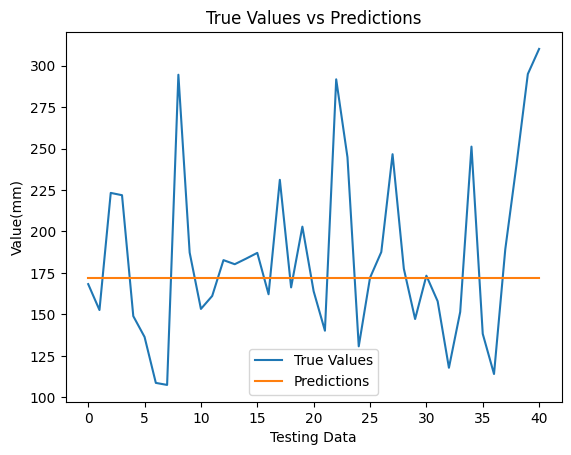

'\nepochc=range(len(y_test))\nepochd=range(len(y_test_predict))\n\nplt.plot(epochc, y_test, \'g\', label=\'real\')\nplt.plot(epochd, y_test_predict, \'b\', label=\'predict\')\nplt.title("Test Data",fontsize=\'30\') #添加标题\nplt.legend((\'real\', \'predict\'),loc=\'upper right\',fontsize=\'15\')\nplt.show()\n'

In [9]:
y_test_predict=model.predict(X_test)
y_test_predict=y_test_predict[:,0]






# Plot the true values and predictions
plt.plot(y_test, label='True Values')
plt.plot(y_test_predict, label='Predictions')
plt.xlabel('Testing Data')
plt.ylabel('Value(mm)')
plt.title('True Values vs Predictions')
plt.legend()
plt.show()




'''
#在测试集上的预测
y_test_predict=model.predict(X_test)
y_test_predict=y_test_predict[:,0]
draw=pd.concat([pd.DataFrame(y_test),pd.DataFrame(y_test_predict)],axis=1);
draw.iloc[200:250,0].plot(figsize=(12,6))
draw.iloc[200:250,1].plot(figsize=(12,6))
plt.legend(('real', 'predict'),loc='upper right',fontsize='15')
plt.title("Test Data",fontsize='30') #添加标题
#展示在测试集上的表现 

y_test_predict = model.predict(X_test).flatten()
y_test_predict=y_test_predict[:,0]
a = plt.axes(aspect='equal')
plt.scatter(y_test, y_test_predict)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 100]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
'''
'''
epochc=range(len(y_test))
epochd=range(len(y_test_predict))

plt.plot(epochc, y_test, 'g', label='real')
plt.plot(epochd, y_test_predict, 'b', label='predict')
plt.title("Test Data",fontsize='30') #添加标题
plt.legend(('real', 'predict'),loc='upper right',fontsize='15')
plt.show()
'''

In [10]:
#輸出结果
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import math
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100
print('訓練集上的MAE/MSE/MAPE')
print(mean_absolute_error(y_train_predict, y_train))
print(mean_squared_error(y_train_predict, y_train) )
print(mape(y_train_predict, y_train) )
print('測試集上的MAE/MSE/MAPE')
print(mean_absolute_error(y_test_predict, y_test))
print(mean_squared_error(y_test_predict, y_test) )
print(mape(y_test_predict,  y_test) )
y_var_test=y_test[1:]-y_test[:len(y_test)-1]
y_var_predict=y_test_predict[1:]-y_test_predict[:len(y_test_predict)-1]
txt=np.zeros(len(y_var_test))
for i in range(len(y_var_test-1)):
    txt[i]=np.sign(y_var_test[i])==np.sign(y_var_predict[i])
result=sum(txt)/len(txt)
print('預測漲跌正確:',result)
print('Training Model took: ', fitting_model_time - start_fitting)
#print('训练时间（秒）:',54.56)

end = time.time()
print('TOTAL time spent', end-start)

訓練集上的MAE/MSE/MAPE
41.703923405811715
2764.15434413441
24.243047491279114
測試集上的MAE/MSE/MAPE
39.79790393067814
2894.908845695323
23.135052921911413
預測漲跌正確: 0.0
Training Model took:  270.006472826004
TOTAL time spent 400.6702301502228
